**Escribir una capa ReLU**

$$
ReLU(x) = max(0, x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from typing import List
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

In [2]:
class Capa:
    """
    Clase base para una capa de nuestra red neuronal.
    Todas las capas deben heredar de esta y deben implementar dos métodos: forward y backward.
    """
    def forward(self, x):
        pass
    
    def backward(self, dL_dz, tasa_aprendizaje=0):
        pass

In [3]:
class ReLU(Capa):
    """
    Capa ReLU
    """
    def forward(self, x):
        """
        Método que calcula ReLU(x).

        El tamaño de la salida debe coincidir con la entrada.

        """

        self._entrada_guardada = x  # Necesitamos guardar la entrada
        salida = None
        salida = np.clip(x, 0, None) # el método clip de la librería numpy permite recortar valores fuera del intervalo a los bordes del intervalo para un intervalo dado

        assert salida.shape == x.shape
        return salida

    def backward(self, dL_dz, tasa_aprendizaje=0.):
        """
        dL_dz -- derivada de la función final con respecto a la salida de esta capa.
        La dimensión debe coincidir exactamente con la dimensión
        de x que pasó por el pase hacia adelante.
        tasa_aprendizaje -- no se utiliza, ya que ReLU no contiene parámetros.

        El método debe calcular la derivada dL_dx.

        """
        dz_dx = None
        dz_dx = np.heaviside(self._entrada_guardada, 0)
        
        assert dz_dx.shape == self._entrada_guardada.shape, f"Las dimensiones deben ser iguales. Se obtuvo {dz_dx.shape, self._entrada_guardada.shape}"
        salida = dz_dx * dL_dz
        return salida

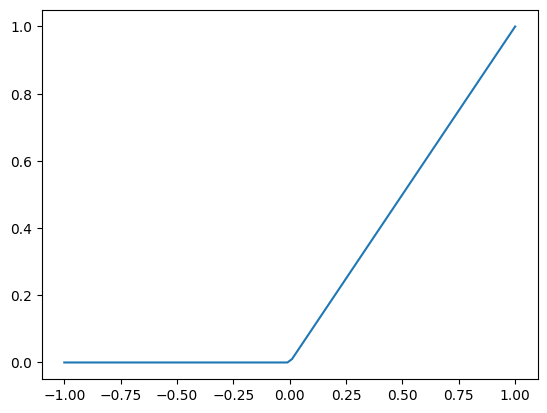

In [5]:
relu = ReLU()

plt.plot(np.linspace(-1, 1, 100), relu.forward(np.linspace(-1, 1, 100)))

**Realización de una capa totalmente conectada**

In [7]:
class CapaFC(Capa):
    """
    Capa totalmente conectada (fully connected/dense)
    """
    def __init__(self, in_dim, out_dim):
        """
        in_dim, out_dim -- número de neuronas de entrada y salida respectivamente

        """
        self.in_dim = in_dim
        self.out_dim = out_dim
        # inicializamos la matriz de pesos (in_dim, out_dim) con una distribución normal
        self.weights = np.random.randn(in_dim, out_dim) * 0.001

        # inicializamos el sesgo con ceros
        self.bias = np.zeros(self.out_dim)
        self._entrada_guardada = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Cálculo de la salida de la capa totalmente conectada.

        x -- entrada de la capa, dimensionalidad (N, in_dim), donde N es el número de objetos en el lote

        return: matmul(x, weights) + bias
        """
        assert np.ndim(x) == 2
        assert x.shape[1] == self.in_dim
        self._entrada_guardada = x

        salida = np.dot(x, self.weights) + self.bias
        
        assert salida.shape == (x.shape[0], self.out_dim), (salida.shape, (x.shape[0], self.out_dim))
        return salida
    
    def backward(self, dL_dz, tasa_aprendizaje=0.):
        """
        dL_dz -- derivada de la función final con respecto a la salida de esta capa.
        Dimensionalidad (N, self.out_dim).
        tasa_aprendizaje -- si no es cero, los parámetros
        de la capa (weights, bias) se actualizarán con la llamada a esta función

        El método debe calcular la derivada dL_dx.
        
        """
        assert np.ndim(dL_dz) == 2
        assert dL_dz.shape[1] == self.out_dim

        self.dL_dw = np.dot(self._entrada_guardada.T, dL_dz)
        self.dL_dx = np.dot(dL_dz, self.weights.T)
        self.dL_db = dL_dz.sum(0) 
        
        assert self.dL_db.shape == self.bias.shape
        assert self.dL_dw.shape == self.weights.shape
        assert self.dL_dx.shape == self._entrada_guardada.shape

        if tasa_aprendizaje != 0:
            self.weights -= tasa_aprendizaje * self.dL_dw
            self.bias -= tasa_aprendizaje * self.dL_db
        
        return self.dL_dx


In [9]:
def entropia_cruzada_multiclase_con_logits(logits, y_true):
    """
    logits -- salida de la red neuronal sin activación. Dimensión: (N, k),
              donde N es la cantidad de objetos y k es la cantidad de clases
    y_true -- clases reales para N objetos

    La función devuelve un vector de pérdidas para cada objeto
    
    """

    logits_para_respuestas = logits[np.arange(len(logits)), y_true]
    
    entropia_cruzada = -logits_para_respuestas + np.log(np.sum(np.exp(logits), axis=-1))
    
    return entropia_cruzada

def gradiente_entropia_cruzada_multiclase_con_logits(logits, y_true):
    """
    logits -- salida de la red neuronal sin activación. Dimensión: (N, k),
              donde N es la cantidad de objetos y k es la cantidad de clases
    y_true -- clases reales para N objetos

    La función devuelve la matriz de derivadas.
    
    """
    unos_para_respuestas = np.zeros_like(logits)
    unos_para_respuestas[np.arange(len(logits)), y_true] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    
    return (- unos_para_respuestas + softmax) / logits.shape[0]


**Implementación de la clase Network.**

In [10]:
class RedNeuronal:
    """
    Red neuronal

    """
    def __init__(self, capas: List[Capa]):
        """
        Para inicializar la red neuronal, necesitamos una lista de capas que deben aplicarse secuencialmente entre sí.

        """
        self.capas = capas
    
    def forward(self, x: np.ndarray):
        """
        x -- lote de objetos de entrada de tamaño (N, tamaño_entrada_primera_capa)
        
        Dado x como entrada, la red debe aplicar cada capa a ella en secuencia.
        Es decir, la salida de cada capa es la entrada de la siguiente.

        x -> capa_0 -> capa_1 ... -> ultima_capa

        """
        salida = None
        salida = x
        for capa in self.capas:
            salida = capa.forward(salida)
        return salida

    def predecir(self, x):
        """
        x -- lote de objetos de entrada de tamaño (N, tamaño_entrada_primera_capa)
        
        La función debe devolver un vector de tamaño (N) con el número de clase predicha
        para cada objeto. 

        """
        logits = self.forward(x) # calculamos los logitos haciendo un pase directo completo de la red
        clases = None
        clases = np.argmax(logits, axis=1)
        assert clases.shape == (x.shape[0],)
        return clases
    
    def paso_entrenamiento(self, x, y, tasa_aprendizaje):
        """
        x -- lote de objetos de entrada de tamaño (N, tamaño_entrada_primera_capa)
        y -- clases reales de los objetos (N)

        """
        logits = self.forward(x)
        perdida = entropia_cruzada_multiclase_con_logits(logits, y)
        gradiente_perdida = gradiente_entropia_cruzada_multiclase_con_logits(logits, y)
        
        gradiente = gradiente_perdida
        for capa in reversed(self.capas):
            gradiente = capa.backward(gradiente, tasa_aprendizaje)
        return np.mean(perdida)
    
    def ajustar(self, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, tasa_aprendizaje, num_epocas, tamaño_lote):
        """
        El bucle de entrenamiento ya está implementado. Su tarea principal es iterar sobre 
        los mini lotes y llamar a train_step en cada uno de ellos, que ya has implementado.

        De lo contrario, es la presentación de informes de pérdidas, precisión y trazado de gráficos.

        """
        registro_entrenamiento = []
        registro_prueba = []
        registro_perdida = []

        for epoca in range(num_epocas):
            perdida_iters = []
            for x_lote,y_lote in iterate_minibatches(x_entrenamiento, y_entrenamiento, tamaño_lote, shuffle=True):
                perdida_iters.append(self.paso_entrenamiento(x_lote, y_lote, tasa_aprendizaje=tasa_aprendizaje))

            registro_perdida.append(np.mean(perdida_iters)) # para visualización, promediamos la pérdida por cada iteración
            precisión_entrenamiento = accuracy_score(y_entrenamiento, self.predecir(x_entrenamiento))
            precisión_prueba = accuracy_score(y_prueba, self.predecir(x_prueba))
            registro_entrenamiento.append(precisión_entrenamiento)
            registro_prueba.append(precisión_prueba)

            clear_output()
            print("Época", epoca)
            print("Precisión en entrenamiento:", registro_entrenamiento[-1])
            print("Precisión en prueba:", registro_prueba[-1])
            plt.figure(figsize=(10, 5))
            ax1 = plt.subplot(1,2,1)    
            plt.plot(registro_entrenamiento,label='precisión en entrenamiento')
            plt.plot(registro_prueba,label='precisión en prueba')
            ax2 = plt.subplot(1,2,2)
            plt.plot(registro_perdida,label='pérdida')
            ax1.legend(loc='best')
            ax2.legend(loc='best')
            plt.grid()
            plt.tight_layout()
            plt.show()

def iterate_minibatches(inputs, targets, tamaño_lote, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - tamaño_lote + 1, tamaño_lote)):
        if shuffle:
            indices_lote = indices[start_idx:start_idx + tamaño_lote]
        else:
            indices_lote = slice(start_idx, start_idx + tamaño_lote)
            
        yield inputs[indices_lote], targets[indices_lote]


**Enseñanza**

In [11]:
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")


11490434/11490434 [==============================] - 2s 0us/step
(60000, 784) (10000, 784)


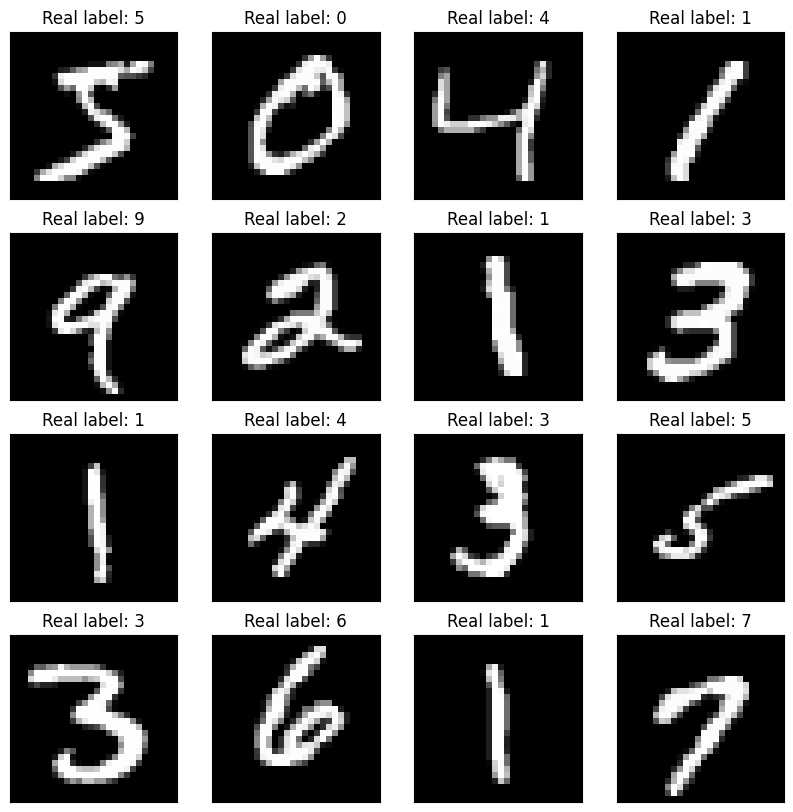

In [12]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

show_mnist(train_images, train_labels)

# convertir imágenes a la forma deseada
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32') / 255.
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32') / 255.
print(train_images.shape, test_images.shape)